# Extract MILC output
- Dec 28, 2021

## Description of columns in parse script : 



- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err

In [1]:
! hostname

jupyter-venkitesh


In [2]:
import os, glob
import subprocess as sp
import numpy as np
import shutil

import re

import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import *

import itertools

In [3]:
%matplotlib widget

In [4]:
top_dir='/gpfs/alpine/lgt104/proj-shared/ayyar/runs_frontier/runs_jan27_2023'

op_dict={
'cg_summit_144':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/cg_144/output-cg_144_summit.kpp',
'cg_crusher_144':'~/mg_output_files/output-cg_144_crusher.kpp',
'cg_summit_192':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/cg_192/output-cg_192_summit.kpp',
'cg_frontier_192':' ~/mg_output_files/output-cg_192_frontier.kpp',
'cg_frontier_192_split':'~/mg_output_files/output-cg_192_frontier_with_split.kpp',

'cg_frontier_144_split':'~/mg_output_files/output-cg_144_frontier_with_split.kpp',
'summit_144_savingNN'   :'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/run_144/output-full_1_savingNN.kpp',
# 'summit_144_loadingNN':'',
    
'old_crusher_2_hprec':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_crusher/runs_feb2_2023_mpich8.1.12/output-full-2.kpp',
'crusher_latest_144_savingNN':'~/mg_output_files/output-full_1_savingNN.kpp',
'crusher_latest_144_readingNN':'~/mg_output_files/output-full_2_readingNN.kpp',
'frontier_144_savingNN':'~/mg_output_files/output-full_1_savingNN_144_frontier.kpp',

# 'summit_192_wrong_ip': '/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/run_192/output-full-run-2_wrong_mgparams.kpp',
'summit_192': '/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/run_192/output-full-run-1.kpp',

# 'frontier_192_wrong_ip': '~/output-full_11_final_complete.kpp',
'frontier_192': '~/mg_output_files/output-full_1_correct_ip.kpp',
}

# list(op_dict.keys())
# list(op_dict.values())

In [5]:
# cmd='./parse.sh %s mg '%(fname1)
# op=sp.check_output(cmd,shell=True,text=True)

## New way in python
# cmd=['./parse.sh',' '+fname1,'mg', ' > op0.out']
# print(cmd)
# op=sp.run(cmd,check=True,capture_output=True,text=True).stdout


In [6]:
## Parse output files

op_files=[]
for count,fl in enumerate(list(op_dict.values())):
    op_file='op%s.out'%(count)
    run_type='cg' if count<5 else 'mg'   ## Assume first 3 runs are cg, rest mg ##!
    print(fl,run_type)
    cmd='./parse.sh %s %s > %s'%(fl,run_type,op_file)
    op=sp.check_output(cmd,shell=True,text=True)
    
    ## Run bash script to parse output
    # cmd=['./parse.sh',fl,run_type,' > op%s.out'%(count+1)]
    # op=sp.run(cmd,check=True,capture_output=True,text=True)
    
    print(cmd)
    print(op)
    ## Append output file names to list
    op_files.append(op_file)

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/cg_144/output-cg_144_summit.kpp cg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/cg_144/output-cg_144_summit.kpp cg > op0.out

~/mg_output_files/output-cg_144_crusher.kpp cg
./parse.sh ~/mg_output_files/output-cg_144_crusher.kpp cg > op1.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/cg_192/output-cg_192_summit.kpp cg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_june8_2023/cg_192/output-cg_192_summit.kpp cg > op2.out

 ~/mg_output_files/output-cg_192_frontier.kpp cg
./parse.sh  ~/mg_output_files/output-cg_192_frontier.kpp cg > op3.out

~/mg_output_files/output-cg_192_frontier_with_split.kpp cg
./parse.sh ~/mg_output_files/output-cg_192_frontier_with_split.kpp cg > op4.out

~/mg_output_files/output-cg_144_frontier_with_split.kpp mg
./parse.sh ~/mg_output_files/output-cg_144_frontier_with_split.kpp mg > op5.out

/gpfs/alpine/lgt104/proj-shared/ayya

In [7]:
names=list(op_dict.keys())

    
df_data=pd.DataFrame([])

count=0
for op_file, name in zip(op_files,names):
    print(op_file,name)
    with open(op_file,'r') as f:
        lst=f.readlines()

    print(lst)
    dict_values={}
    dict_values['name']=name
    # Add masses
    keys=lst[0].rstrip('\n').split(' ')
    vals=lst[1].rstrip('\n').split(' ')

    # Add timings
    keys+=lst[2].rstrip('\n').split(' ')
    vals+=lst[3].rstrip('\n').split(' ')

    # Add values to dictionary
    for k,v in zip(keys,vals):
        dict_values[k]=np.float64(v)

    # df_data=df_data.append(dict_values,ignore_index=True)
    df_data=pd.concat([df_data,pd.DataFrame(dict_values,index=[count])])
    count+=1

cols=['name', 'startup', 'loading', 'mg-setup',
       'make/save-src', 'mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-01-10',
       'mass-11-20', 'solve-time','contractions', 'quda-total-time','summed-time', 'error',
       'milc-total-time']

df_data=df_data[cols].copy()

op0.out cg_summit_144
['mass-01-10 mass-11-20\n', '6.4975873000000001e+02 9.3773073199999999e+01\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '8.766544e+01 3.419834e+02 0 1.4870636064000000e+03 2.021131e+02 1.869174e+02 2.3057429463999997e+03 1667.382 2.332431e+03 2.668805360000033e+01\n']
op1.out cg_crusher_144
['mass-01-10 mass-11-20\n', '3.9220819000000000e+02 5.5289390299999980e+01\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '3.729403e+01 6.951410e+02 0 8.9499516059999996e+02 2.436905e+01 3.297167e+02 1.9815159406000000e+03 979.632 1.999218e+03 1.770205940000005e+01\n']
op2.out cg_summit_192
['mass-01-10 mass-11-20\n', '9.8947454999999991e+02 1.8679390319999999e+02\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '2.359905e+02 5.667821e+02 0 2.35253690639999

In [8]:
df_data

,name,startup,loading,mg-setup,make/save-src,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,contractions,quda-total-time,summed-time,error,milc-total-time
0,cg_summit_144,87.66544,341.9834,0.000000,202.113100,NaN,NaN,NaN,NaN,649.758730,93.773073,1487.063606,186.917400,1667.382,2305.742946,26.688054,2332.431000
1,cg_crusher_144,37.29403,695.1410,0.000000,24.369050,NaN,NaN,NaN,NaN,392.208190,55.289390,894.995161,329.716700,979.632,1981.515941,17.702059,1999.218000
2,cg_summit_192,235.99050,566.7821,0.000000,199.644200,NaN,NaN,NaN,NaN,989.474550,186.793903,2352.536906,254.143500,2569.479,3609.097206,53.276794,3662.374000
3,cg_frontier_192,93.97120,702.9465,0.000000,5.348363,NaN,NaN,NaN,NaN,586.894355,103.030642,1379.849995,405.427000,1481.877,2587.543058,26.925942,2614.469000
4,cg_frontier_192_split,82.99784,700.0259,0.000000,4.231502,NaN,NaN,NaN,NaN,596.514875,97.212432,1387.454614,411.606500,1485.105,2586.316356,26.888644,2613.205000
5,cg_frontier_144_split,29.99796,696.4853,1163.498412,341.954800,0.000000,0.000000,0.000000,521.964200,NaN,59.785006,22.039870,2253.976342,2271.680,1244.695000,NaN,17.703658
6,summit_144_savingNN,84.89080,303.3417,6240.440000,111.549900,18.804819,14.653286,15.983072,235.582000,NaN,91.022273,752.090898,180.558300,7289.999,7672.871598,147.206402,7820.078000
7,old_crusher_2_hprec,48.23773,822.7423,4040.290000,73.978930,26.333695,20.974092,21.218190,148.638410,NaN,66.783495,567.895762,417.200400,4744.151,5970.345122,83.552878,6053.898000
8,crusher_latest_144_savingNN,32.90049,621.4185,5284.530000,25.099540,25.610843,20.008936,18.849449,117.502115,NaN,60.959802,485.862291,324.475200,5786.845,6774.286021,21.643979,6795.930000
9,crusher_latest_144_readingNN,33.86708,621.0733,1304.450000,23.698480,25.559431,19.966361,18.756003,116.581185,NaN,61.248650,484.223261,312.201400,1799.522,2779.513521,17.191479,2796.705000




- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err




In [9]:
# df_data.iloc[[3,10,11]]
# df_data.iloc[[2,5,7,8,9]]
# df_data.iloc[[3,8,11]]

In [10]:
df=df_data.copy()
times_lst=['mass-01', 'mass-02', 'mass-03', 'mass-04-10',
       'mass-11-20', 'startup', 'loading', 'mg-setup', 'solve-time',
       'make/save-src', 'contractions', 'quda-total-time','summed-time', 'error',
       'milc-total-time']

# for col in times_lst:
    # df[col]=df[col]*df['gpu_factor']
    
df[:]

,name,startup,loading,mg-setup,make/save-src,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,contractions,quda-total-time,summed-time,error,milc-total-time
0,cg_summit_144,87.66544,341.9834,0.000000,202.113100,NaN,NaN,NaN,NaN,649.758730,93.773073,1487.063606,186.917400,1667.382,2305.742946,26.688054,2332.431000
1,cg_crusher_144,37.29403,695.1410,0.000000,24.369050,NaN,NaN,NaN,NaN,392.208190,55.289390,894.995161,329.716700,979.632,1981.515941,17.702059,1999.218000
2,cg_summit_192,235.99050,566.7821,0.000000,199.644200,NaN,NaN,NaN,NaN,989.474550,186.793903,2352.536906,254.143500,2569.479,3609.097206,53.276794,3662.374000
3,cg_frontier_192,93.97120,702.9465,0.000000,5.348363,NaN,NaN,NaN,NaN,586.894355,103.030642,1379.849995,405.427000,1481.877,2587.543058,26.925942,2614.469000
4,cg_frontier_192_split,82.99784,700.0259,0.000000,4.231502,NaN,NaN,NaN,NaN,596.514875,97.212432,1387.454614,411.606500,1485.105,2586.316356,26.888644,2613.205000
5,cg_frontier_144_split,29.99796,696.4853,1163.498412,341.954800,0.000000,0.000000,0.000000,521.964200,NaN,59.785006,22.039870,2253.976342,2271.680,1244.695000,NaN,17.703658
6,summit_144_savingNN,84.89080,303.3417,6240.440000,111.549900,18.804819,14.653286,15.983072,235.582000,NaN,91.022273,752.090898,180.558300,7289.999,7672.871598,147.206402,7820.078000
7,old_crusher_2_hprec,48.23773,822.7423,4040.290000,73.978930,26.333695,20.974092,21.218190,148.638410,NaN,66.783495,567.895762,417.200400,4744.151,5970.345122,83.552878,6053.898000
8,crusher_latest_144_savingNN,32.90049,621.4185,5284.530000,25.099540,25.610843,20.008936,18.849449,117.502115,NaN,60.959802,485.862291,324.475200,5786.845,6774.286021,21.643979,6795.930000
9,crusher_latest_144_readingNN,33.86708,621.0733,1304.450000,23.698480,25.559431,19.966361,18.756003,116.581185,NaN,61.248650,484.223261,312.201400,1799.522,2779.513521,17.191479,2796.705000


In [11]:
sub_list=['name','mg-setup','solve-time','milc-total-time']
df[sub_list]

,name,mg-setup,solve-time,milc-total-time
0,cg_summit_144,0.000000,1487.063606,2332.431000
1,cg_crusher_144,0.000000,894.995161,1999.218000
2,cg_summit_192,0.000000,2352.536906,3662.374000
3,cg_frontier_192,0.000000,1379.849995,2614.469000
4,cg_frontier_192_split,0.000000,1387.454614,2613.205000
5,cg_frontier_144_split,1163.498412,22.039870,17.703658
6,summit_144_savingNN,6240.440000,752.090898,7820.078000
7,old_crusher_2_hprec,4040.290000,567.895762,6053.898000
8,crusher_latest_144_savingNN,5284.530000,485.862291,6795.930000
9,crusher_latest_144_readingNN,1304.450000,484.223261,2796.705000


In [12]:
sub_list=['name','mg-setup','mass-01', 'mass-02', 'mass-03', 'mass-04-10','mass-01-10',
       'mass-11-20', 'solve-time','milc-total-time']
df[sub_list].fillna('-')



# 192
# df[sub_list].iloc[[3,10,11]]

# 144
# df[sub_list].fillna('-').iloc[[2,5,7,9]]


# 144 vs 192 frontier
# df[sub_list].fillna('-').iloc[[8,11]]


# cg comparison

df[sub_list].iloc[[2,3,4,5]][['name','mg-setup','mass-01-10','mass-11-20', 'solve-time','milc-total-time']]

,name,mg-setup,mass-01-10,mass-11-20,solve-time,milc-total-time
2,cg_summit_192,0.000000,989.474550,186.793903,2352.536906,3662.374000
3,cg_frontier_192,0.000000,586.894355,103.030642,1379.849995,2614.469000
4,cg_frontier_192_split,0.000000,596.514875,97.212432,1387.454614,2613.205000
5,cg_frontier_144_split,1163.498412,NaN,59.785006,22.039870,17.703658


## Plots

,name,summed-time
0,cg_summit_144,2305.742946
1,cg_crusher_144,1981.515941
2,cg_summit_192,3609.097206
3,cg_frontier_192,2587.543058
4,cg_frontier_192_split,2586.316356
5,cg_frontier_144_split,1244.695000
6,summit_144_savingNN,7672.871598
7,old_crusher_2_hprec,5970.345122
8,crusher_latest_144_savingNN,6774.286021
9,crusher_latest_144_readingNN,2779.513521


['cg_summit_144' 'cg_crusher_144' 'cg_summit_192' 'cg_frontier_192'
 'cg_frontier_192_split' 'cg_frontier_144_split' 'summit_144_savingNN'
 'old_crusher_2_hprec' 'crusher_latest_144_savingNN'
 'crusher_latest_144_readingNN' 'frontier_144_savingNN' 'summit_192'
 'frontier_192'] [2305.7429464 1981.5159406 3609.0972064 2587.5430577 2586.3163556
 1244.695     7672.8715982 5970.3451224 6774.2860207 2779.5135209
 6387.4135227 3310.9427659 9311.449054 ]


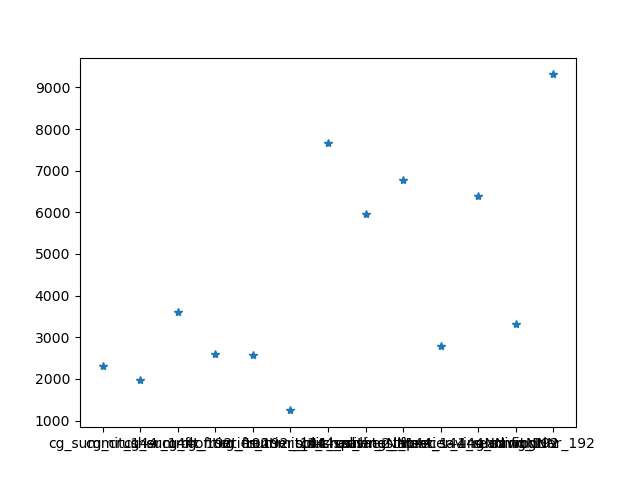

In [13]:
y_options=['mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-11-20',
       'startup', 'loading', 'mg-setup', 'solve-time', 'make/save-src',
       'contractions', 'summed-time', 'quda-total-time', 'milc-total-time',
       'error', 'mass-01-10']


def f_compare_plot(df,y,x='name'):
    # df.plot(x=x,y=y,kind='line',marker='D')
    
    display(df[[x,y]])
    
    x=df.name.values
    y=df[y].values
    print(x,y)
    plt.figure()
    plt.plot(x,y,marker='*',linestyle='')
    # plt.plot(y,marker='*')
    # plt.legend()
    plt.show()
    
# df.plot(x='name',y='summed-time',kind='line',marker='*')
f_compare_plot(df,'summed-time','name')

In [14]:
interact(f_compare_plot,df=fixed(df),y=y_options,x=fixed('name'))

interactive(children=(Dropdown(description='y', options=('mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-…

<function __main__.f_compare_plot(df, y, x='name')>

In [17]:
def f_plot_together(df,labels_lst,markers_lst): 
    plt.figure()
    x=df.name.values

    for label,marker in zip(labels_lst,markers_lst):
        y=df[label].values
        plt.plot(x,y,marker=marker,label=label)

    plt.legend()


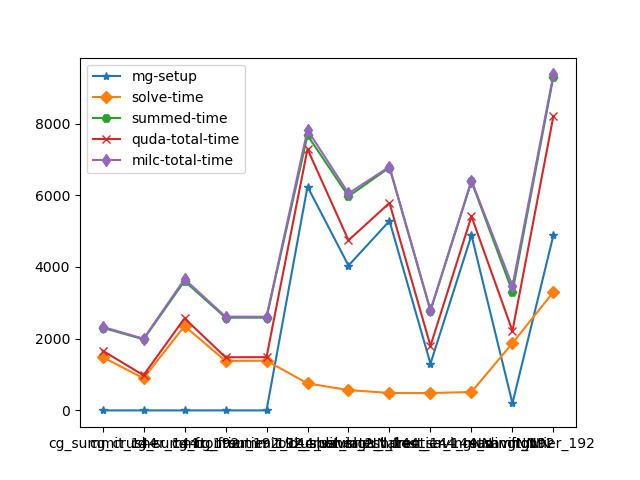

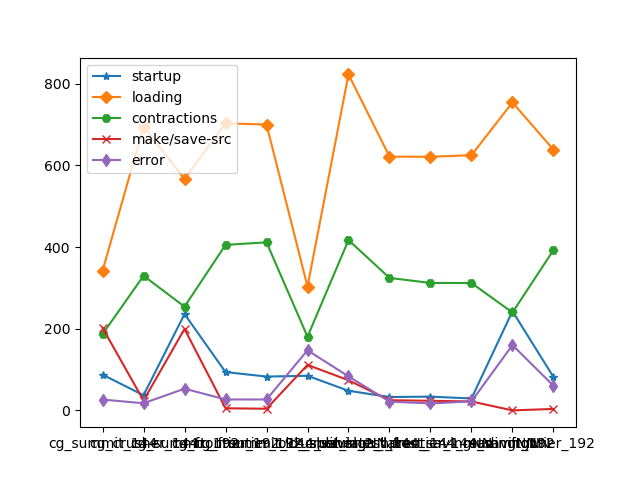

In [18]:
markers=['*','D','H','x','d','p','1','2','h','v']
labels=['startup', 'loading', 'mg-setup', 'solve-time', 'make/save-src',
       'contractions', 'summed-time', 'quda-total-time', 'milc-total-time',
       'error']

labels1=['mg-setup', 'solve-time','summed-time', 'quda-total-time', 'milc-total-time']

labels2=['startup', 'loading','contractions','make/save-src','error']

f_plot_together(df,labels1,markers)
f_plot_together(df,labels2,markers)
